In [72]:
#math and linear algebra stuff
import numpy as np
import numpy.linalg as la

#Latex rendering
from IPython.display import display, Math, Latex

#plots
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15.0, 15.0)
#mpl.rc('text', usetex = True)
import matplotlib.pyplot as plt
%matplotlib inline

# Krylov space based methods


## Taylor expansion: from scalar to matrices
	
Taylor expansion can easily be applied over differentiable scalar functions of one variables, this leads for instance to the following expansion, for $x$ close to $0$:

\begin{align*}
  \frac{1}{1-x} &= 1 + x + x^2 + x^3 + ... \\
  &= \sum_{n=0}^{\infty} x^n
\end{align*}

It is interesting to notice that the right part of this equality can also be interpreted as the sum of all terms of a geometric series with a common ratio of $x$, which is valid when $|x| < 1$.

For the sake of our argument, we will assume that, $M$ is symmetric, so that all its power can be simultaneously diagonalised in the same eigen space, so that we juste have to extrapolate the scalar case to each diagonal elements.
The previous expansion extended to the symmetric matrices case over a real field then reads:

\begin{align*}
  (Id - M)^{-1} &= Id + M + M^2 + M^3 + ... \\
  &= \sum_{n=0}^{\infty} M^n
\end{align*}

This expansion is valid for matrices whose operator norm $\|M\| = |\lambda(M)_{max}|  < 1 $, and of course apply for nilpotent matrices, which have all their eigenvalues identically equal to zero, their characteristic polynomial being $x^n$.

Using $|\lambda(M)_{max}| =  c \neq 0 $, excluding the already handled case of nilpotent matrices, we can extend the previous power series to all symmetric matrices M:

\begin{align*}
    \left( Id - \left( \frac{M}{c}\right) \right)^{-1} &= Id + \frac{M}{c} + \left(\frac{M}{c} \right)^2 + \left(\frac{M}{c} \right)^3 + \; \dots \\
    (c Id - M)^{-1} &= \frac{1}{c} \left( Id + \frac{M}{c} + \left(\frac{M}{c} \right)^2 + \left(\frac{M}{c} \right)^3 + ... \right) \\
    &= \frac{1}{c} \sum_{n=0}^{\infty} \left(\frac{M}{c} \right)^n
\end{align*}

Withou loss of generality, a variable change $M = c Id - P$, where $P$ is also symmetric, gives us

\begin{equation}
    P^{-1} = \frac{1}{c} \sum_{n=0}^{\infty} \left(\frac{c Id - P}{c} \right)^n
\end{equation}

We will see how this Taylor expansion is linked to preconditionned iterations in the next section

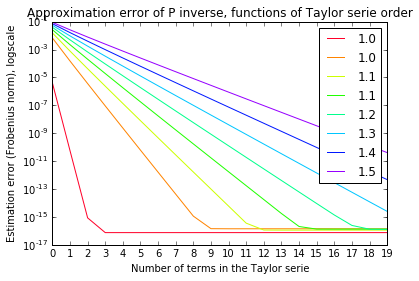

In [73]:
"""
Let see if this method work, on a well conditionned matrix:
to do so, we directly generates random symmetric matrix,
and then tune its spetrum to an arbitrarily well conditionned
matrix
"""
size = 20
P = np.random.rand(size,size)
P = np.dot(P,P.T)
[v,Q] = np.linalg.eigh(P)

#generate arbitrary good conditionning
NB_SAMPLE = 8
nb_taylor = 20
condstep = np.linspace(1+1e-5, 1+1e-1,NB_SAMPLE)
cm = plt.get_cmap('gist_rainbow')
colors = [cm(1.*i/NB_SAMPLE) for i in range(NB_SAMPLE)]
plt.figure()
plt.title( "Approximation error of P inverse, functions of Taylor serie order")
plt.xticks(range(nb_taylor))
plt.xlabel("Number of terms in the Taylor serie")
plt.ylabel("Estimation error (Frobenius norm), logscale")
plt.yscale('log')

for cond,color in zip(condstep,colors):
    P = np.dot(Q,np.dot(np.diag(10+np.cumprod(cond*np.ones(size))),Q.T))
    c=np.max(np.linalg.eigvals(P))
    condNum = c/np.min(np.linalg.eigvals(P))
    realP1 = np.linalg.inv(P)
    ratio = (np.identity(size)-P/c)
    Pn = np.identity(size)
    P1 = Pn.copy()
    frobError = [np.linalg.norm(realP1-P1/c)]
    #Taylor serie sum
    for i in range(nb_taylor-1):
        Pn = np.dot(Pn,ratio)
        P1 += Pn
        frobError.append(np.linalg.norm(realP1-P1/c))

    plt.plot(range(nb_taylor),frobError,
             color=color,label="{0:.1f}".format(condNum))

plt.legend()

## Krylov Subspaces methods

### Introduction: preconditionned iterations

#### Yet another fixed point iteration method

The approach seen in the notebook called FixedPointIterationsMethods, with a-priori decomposition of the matrix $M$ that lead to a fixed point iterations can also be generalized as follows:

\begin{align*}
  M \vec{x} - \vec{y} &= 0\\
  (P-(P-M)) \vec{x} - \vec{y} &= 0\\
  P \vec{x} &= (P-M) \vec{x} + \vec{y} \\
  P^{-1} P \vec{x} &= P^{-1}(P-M) \vec{x} + P^{-1} \vec{y} \\
  \vec{x} &= \vec{x} + P^{-1} ( \vec{y} - M \vec{x} )
\end{align*}

This problem can simply be recasted as a fixed point search problem, that can be solved using the following iterations:

\begin{align*}
  \vec{x^{k+1}} = \vec{x^k} + P^{-1} ( \vec{y} - M \vec{x^k} ) \\
  \vec{x^{k+1}} = \vec{x^k} + P^{-1} \vec{r^k}
\end{align*}

or

\begin{equation}
  \vec{x^{k+1}} = (Id-P^{-1}M)\vec{x^k} + P^{-1}\vec{y}
\end{equation}

Where $ \vec{r^k} = \vec{y} - M \vec{x^k} $ is called the residual and $P$ is called the preconditionner.

As seen in the notebook FixedPointIterationsMethods, according to the Picard fixed point theorem, the preconditioned iterations algorithm converges if the operator $T : \vec{x} \rightarrow ( Id . + P^{-1} ( \vec{y} - M . ) ) \vec{x}$ is a strict contraction, i.e if there exists $\rho \in [0,1[$ such that

\begin{align*}
  \forall (x,x') \in \mathbb{R}^n \times \mathbb{R}^n \; &\|Tx - Tx'\| \leq \rho \|x-x'\| \\
  &\|(Id-P^{-1}M)(x-x')+P^{-1}\vec{y}-P^{-1}\vec{y}\| \leq \rho \|x-x'\| \\
  &\|(Id-P^{-1}M)(x-x')\| \leq \rho \|x-x'\| \\
\end{align*}

This condition reduces to the constraint that the maximal singular value of $(Id-P^{-1}M) .$ should lie inside $[0,1[$.
Using the property of commuting matrices implying that they are diagonalizable in the same eigenspace, we can say that the eigen values of the sum $Id-P^{-1}M$ are the sum of the eigen values of $Id$, which are respectively identically $1$ and $-P^{-1}M$.

This general property of commuting matrices can be trivially obtained for the specific case of the Identity:

\begin{align*}
  (Id-A) \vec{x} &= x - \lambda \vec{x} \quad \forall \lambda \in \lambda(A)_i, i \in [0,\dots,n] \\
  (Id-A) \vec{x} &= (1-\lambda) \vec{x} \\
\end{align*}

This help us to derive the initial constraint over $Id-P^{-1}M$ as a constraint only over $P^{-1}M$:
	
\begin{equation}
  0 \le \lambda(P^{-1}M)_{max} \leq 1  
\end{equation}

In addition, the preconditionner could feature some useful properties, like the fact that $P^{-1}$ is easy to compute, and eventually $P$ has a low condition number, or $P$ may even carry some a-priori informations over the problem.

We can notice that, if we choose the preconditionner such that $P^{-1} = \frac{1}{\lambda(M^\intercal M)_{max}} M^\intercal $ we get an instance of the gradient descent algorithm.

### What are Krylov subspaces, and how are they linked to the solution of a linear system
  
Let reconsider the equation of preconditionned iterations, where we will incorporate the preconditionner $P$ directly to $M$ and $y$ such that we have our new $M$ equivalent to $P^{-1}M$ and our new $y$ equivalent to $P^{-1}\vec{y}$. The preconditionned iterations now reads
 
\begin{equation}
  \vec{x^{k+1}} = (Id-M)\vec{x^k} + \vec{y}
\end{equation}

assuming $\vec{x^{0}} = \vec{y}$, we can write

\begin{align*}
  \vec{x^{0}} &= \vec{y} \\
  \vec{x^{1}} &= (Id-M)\vec{y} + \vec{y} \\
  \vec{x^{2}} &= (Id-M)^2\vec{y} + (Id-M)\vec{y} + \vec{y} \\
\end{align*}

Now, using the matrix version of the Taylor expansion exposed in the previous section, we can give another proof of the convergence of the $x^k$ series:

\begin{align*}
  \vec{x^{k}} &= \sum_{n=0}^{k} (Id-M)^n \vec{y} \\
  \underset{k\rightarrow \infty}{lim} \; \vec{x^{k}} &= (Id-(Id-M))^{-1} \vec{y} \\
  \underset{k\rightarrow \infty}{lim} \; \vec{x^{k}} &= M^{-1} \vec{y} \\
\end{align*}

The fact that the inverse of $M$ in $\vec{y}$ can be expressed in a basis made of vectors of the form $M^n \vec{y}, n \in 0,1,\dots$ was first discovered by Krylov, using a more general approach based on the Cayley-Hamilton theorem, which do not impose condition over the spectral radius, and where the polynomial in $M$ was the characteristic polynomial of the matrix $M$.

In the general case, the space $\mathcal{K}_r$ spanned by the $r$ first vectors : $M^n \vec{y}, n \in 0,1,\dots, r-1 $ is known as the order-r Krylov subspace, and it can be shown that its basis, made of the vectors $M^n \vec{y}, n \in 0,1,\dots, r-1$ is free while $r \leq r_{max}$.

First, proving that the basis of $\mathcal{K}_1$ is free is direct, because there is only one vector, then, as linear combinations of Krylov basis generates a vector in $\mathbb{R}^n$ for the $n \times n$ matrix $M$ Krylov subspace $\mathcal{K}_r$ dimension cannot exceed $n$ in any case, so a free basis of $\mathcal{K}_r$ cannot contain more than $n$ vectors.

Now we have to show that if only one more vector $M^{k+1} \vec{y}$ makes the basis $M^n \vec{y}, n \in 0,1,\dots,k, k+1$ linearly dependant, then $k+1=r_{max}$ and all following basis vectors will also be linearly dependant.

We will give the intuition of the proof using a reccurence strategy showing that if $M^{k+1} \vec{y} \in \mathcal{K}_{r_{max}}$ then $ \forall q > 0, M^{k+q} \in \mathcal{K}_{r_{max}}$:

We begin assuming that the property is true for one $q_0$ : $\exists q_0 \leq 0 \backslash M^{r+q_0} \in \mathcal{K}_r$ and see what happen for $q_0+1$:

\begin{align*}
  M^{r+q_0} \vec{y} &\in \mathcal{K}_r \\
  M^{r+q_0} \vec{y} &= \sum_{n=0}^{r-1} \alpha_n M^{n} \vec{y} \\
  M^{r+q_0+1} \vec{y} &= M \sum_{n=0}^{r-1} \alpha_n M^{n} \vec{y} \\
  &= \sum_{n=0}^{r-1} \alpha_n M^{n+1} \vec{y} \\
  &= \sum_{n=1}^{r-1} \alpha_{n-1} M^{n} \vec{y} + \alpha_{r-1} M^{r} \vec{y} \; \text{ and as } r-1 < r \leq r+q_0 \\
  &= \sum_{n=1}^{r-1} \alpha_{n-1} M^{n} \vec{y} + \alpha_{r} \sum_{n=0}^{r-1} \beta_n M^{n} \vec{y}\\
  &= \sum_{n=0}^{r-1} \gamma_{n} M^{n} \vec{y}\\
  M^{r+q_0+1} &\in \mathcal{K}_r
\end{align*}

This property shows us that, in $\mathbb{R}^n$, the $\mathcal{K}_{r}$ subspace is possibly of lower dimension than $n$, and that a solution of a linear set of equations may be expressed or approximated within this framework.

### Raw Krylov basis and numerical stability

From the previous section, we can derive the Krylov matrix $K$:

\begin{equation}
  \begin{pmatrix} \vec{y} \; M\vec{y} \; M^2\vec{y} \; \dots \; M^{n-1}\vec{y} \end{pmatrix}
\end{equation}

Unfortunately, in many cases, this basis cannot be used as is to express the solution for numerical reasons: assuming $M$ can be diagonalized and has $n$ different eigenvalues $\lambda(M)_0, \lambda(M)_1, \dots \lambda(M)_{n-1}$ associated with the eigenvectors $ \vec{v_0},  \vec{v_1}, \dots  \vec{v_{n-1}}$ we can write

\begin{align*}
  \vec{y} = \sum_{i=0}^{n-1} \alpha_i  \vec{v_i} \\
  M^n \vec{y} = \sum_{i=0}^{n-1} \alpha_i \lambda(M)_i^n  \vec{v_1}
\end{align*}

Unfortunately, when the ratio $ \left( \frac{\alpha_{max}}{\alpha_i} \right) \left( \frac{\lambda(M)_{max}}{\lambda(M)_i} \right)^n $ where $max$ stands for the index of the maximum eigenvalue, exceeds $2^n$, the accuracy of any krylov subspace method would collapse. n being the number of significand bits in the floating point representation of a computer.

In this case, all numerical approximation of the Krylov basis vectors exceeding order $n$ becomes colinear to the maximum eigenvector $ \vec{v_{max}}$.
In practice, this drawback has a high probability of occurrence especially in high dimensional settings, with for instance $k \gg n$ dimensions, where the first $k$ vectors of the Krylov basis are linearly independants, though potentially carrying some informations about the solution.

#### Arnoldi orthogonalization strategy for Krylov basis

To overcome the numerical stability problem, Arnoldi designed a method able to exploit Krylov basis using Gram-Schmidt orthonormalization process.

This simple method can be summarized as follows:

\begin{algorithm}
  \caption{Generate Arnoldi basis vectors $\vec{v_j}$}
    \begin{algorithmic}
      \STATE \textbf{Initialization}
      \STATE $\vec{v_0} = \frac{\vec{y}}{\| \vec{y} \|}$
      \STATE $j = 1$
      \STATE $\vec{w} = M \vec{v_{0}}$
      \STATE \textbf{Iterations}
      \WHILE{$\vec{w} \neq \vec{0}$ and $j < n$}
      \STATE $\vec{w} = M \vec{v_{j-1}}$
      \FORALL{$i \in 0,\dots j-1$}
        \STATE $\alpha = \langle \vec{w},\vec{v_i} \rangle $
        \STATE $\vec{w} = \vec{w} - \alpha \vec{v_i}$
      \ENDFOR
      \IF{$\vec{w} \neq \vec{0}$}
        \STATE $\vec{v_j} = \frac{\vec{w}}{\| \vec{w} \|}$
      \ENDIF
        \STATE $j=j+1$
       \ENDWHILE
    \end{algorithmic}
\end{algorithm}

Let's define $h_{ij}$ such that:
	
\begin{align*}
  h_{ij} = 
  \begin{cases}
    \langle M\vec{v_j},\vec{v_i} \rangle \; \text{ if } \; j \geq i\\
    \| M\vec{v_j} - \sum_{k=0}^{j} \langle M\vec{v_j},\vec{v_k} \rangle \vec{v_k} \| \; \text{ if } \; i = j+1\\
    0 \; \text{ otherwise }
  \end{cases}
\end{align*}

Where the two first cases corresponds respectively to the orthogonalization coefficients, and the normalization coefficients of the Gram-Schmidt process described earlier.

From there, we can define a $(p+1) \times p$ matrix $H_{p+1 p}$ as follows:

\begin{equation}
  H_{p+1 p} =
  \begin{pmatrix}
   h_{0 0} & h_{0 1} & \dots  & h_{0 p} \\
   h_{1 0} & h_{1 1} & \dots  & h_{1 p} \\
      0	   & h_{2 1} & \ddots & \vdots \\
      0	   & \ddots  & \ddots & h_{pp} \\
      0    &    0    &   0    & h_{p+1 p} \\
  \end{pmatrix}
\end{equation}

If we define $V_p$ as the matrix containing all first $p$ Arnoldi basis vectors $ \vec{v_0},\vec{v_1},\dots,\vec{v_{p-1}}$ as column vectors, given the orthonormal property obtain through Gram-Schmidt, we know that $V_p$ is a unitary matrix, so we have
	
\begin{equation}
  V_p^\intercal V_p = Id_p
\end{equation}

Using the matrix $H_{p+1 p}$, we can write:

\begin{equation}
  M V_p = V_{p+1} H_{p+1p}
\end{equation}

The matrix product $V_{p+1} H_{p+1p}$ allows us to perform the column-wise inversion of the Gram-Schmidt process over $V_{p+1}$ to recover $M V_p$.

From the recurrence relationship based on $H_{p+1 p}$, we can write:

\begin{align*}
  M V_p = V_{p+1} H_{p+1p} \\
  V_p ^\intercal M V_p = V_p ^\intercal V_{p+1} H_{p+1p}
\end{align*}

Using the unitary property of $V_p$, we see that $V_p^\intercal V_{p+1}$ is a $p \times p+1$ matrix composed of a $p \times p$ identity matrix and a last $p+1 ^{th} $ column containing, at each row $i$, the result of $ \langle \vec{v_{p+1}},\vec{v_i} \rangle $ which are all zeros.
We can deduce that $V_p^\intercal V_{p+1}$ will discard the last row of $H_{p+1p}$, and then give $H_{p p}$ :

\begin{equation}
  H_{p p} = V_{p} ^\intercal M V_{p}
\end{equation}

This result is important because, it shows that $H_{p p}$, is the expression of the projection of the linear operator represented by $M$ over the order-p Krylov subspace in the orthonormal basis of Arnolid vectors $V_p$, which can be seen as a rotation matrix.
A point that will be very important in the next section, is that, by construction $H_{p p}$ is a Hessenberg superior matrix,

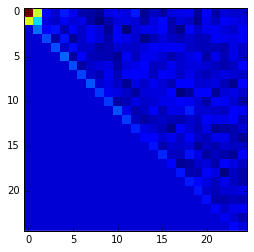

In [74]:
"""
Arnoldi method for basis orthogonalization / equivalent
to matrix factorization as a orthogonal/Hessenberg superior/orthogonal
"""
size = 25
M = np.random.rand(size,size)
y = np.random.rand(size)

#Initialize matrix Vp and Hpp
Vp = np.zeros((size,size))
Hpp = np.zeros((size,size))
Vp[:,0] = y/np.linalg.norm(y)

for i in np.arange(1,size+1):
    #Compute next Vp
    v = np.dot(M,Vp[:,i-1])
    #orthogonalize
    orth = np.dot(Vp[:,:i].T,v)
    Hpp[:i,i-1] = orth
    if( i < size ):
        v = v - np.dot(Vp[:,:i],orth)
        #Update Hpp
        Hpp[i,i-1] = np.linalg.norm(v)
        #Normalize vector and update V
        Vp[:,i] = v / Hpp[i,i-1]

#check orthogonality of Vp
assert( np.allclose(np.identity(size),np.dot(Vp,Vp.T)) )

#Check the equivalence between M and VptHppVp
assert( np.allclose(Hpp,np.dot(Vp.T,np.dot(M,Vp))) )

#Show matrix Hpp
plt.imshow(Hpp,interpolation='none')

### Symmetric matrices and Lanczos method for Krylov basis

If the matrix $M$ is symmetric, following the relation found earlier related to the unitary change of basis $V_p$, it can be easily shown that $H_{p p}$ is also a symmetric matrix:
	
\begin{align*}
  H_{p p} &= V_{p} ^\intercal M V_{p} \\
  H_{p p}^\intercal &= (V_{p} ^\intercal M V_{p})^\intercal \\
  H_{p p}^\intercal &= V_{p} M^\intercal V_{p}^\intercal \\
  H_{p p}^\intercal &= V_{p} M V_{p}^\intercal \\
  H_{p p}^\intercal &= V_{p}^\intercal M V_{p} \\
  H_{p p}^\intercal &= H_{p p} \\
\end{align*}

As, by construction, as seen earlier, $H_{p p}$ is a Hessenberg superior matrix, we can conclude that, in the case of $M$ being, symmetric, we have that $H_{p p}$ is both Hessenberg superior and inferior, so it is a tridiagonal symmetric matrix:

\begin{equation}
  H_{p p} =
  \begin{pmatrix}
    h_{0 0} & h_{0 1} &    0    &    0   &  \dots &   \dots    &   0      \\
    h_{1 0} & h_{1 1} & h_{1 2} &    0   & \ddots &   \ddots   & \vdots   \\
      0	    & h_{2 1} & h_{2 2} & \ddots & \ddots &   \ddots   & \vdots   \\
    \vdots  &    0    & h_{3 2} & \ddots & \ddots &    0       &    0     \\
    \vdots  & \ddots  &     0   & \ddots & \ddots & h_{p-2p-1} &    0     \\
    \vdots  & \ddots  & \ddots  & \ddots & \ddots & h_{p-1p-1} & h_{p-1p} \\
       0    & \dots   &  \dots  &  \dots &    0   & h_{pp-1}   & h_{pp}   \\
  \end{pmatrix}
\end{equation}

This property has a huge impact over the Arnoldi orthogonalisation algorithm seen previously: we can see that the Gram-Schmidt orthogonalization process for the vector $M \vec{v_j}$ will only imply the computation of the correlation with the two previous vectors of the process: $h_{j-2j}$ and $h_{j-1j}$ instead of all previously constructed vectors. The Arnoldi algorithm in this case now reads:

\begin{algorithm}
  \caption{Generate Arnoldi basis vectors $\vec{v_j}$}
    \begin{algorithmic}
      \REQUIRE $M \in S^n_{++}$ the positive definite cone
      \STATE \textbf{Initialization}
      \STATE $\vec{v_0} = \frac{\vec{y}}{\| \vec{y} \|}$
      \STATE $j = 1$
      \STATE $\vec{w} = M \vec{v_{0}}$
      \STATE \textbf{Iterations}
      \WHILE{$\vec{w} \neq \vec{0}$ and $j \leq n$}
      \STATE $\vec{w} = M \vec{v_{j-1}}$
      \IF{$j > 1$}
        \STATE $h_{j-2j-1} = h_{j-1j-2}$
        \STATE $\vec{w} = \vec{w} - h_{j-2j} \vec{v_{j-2}}$
      \ENDIF
      \STATE $h_{j-1j-1} = \langle \vec{w},\vec{v_{j-1}} \rangle $
      \STATE $\vec{w} = \vec{w} - h_{j-1j-1} \vec{v_{j-1}}$
      \IF{$\vec{w} \neq \vec{0}$}
        \STATE $h_{jj-1} = \| \vec{w} \|$
        \STATE $\vec{v_j} = \frac{\vec{w}}{h_{jj-1}}$
      \ENDIF
        \STATE $j=j+1$
       \ENDWHILE
    \end{algorithmic}
\end{algorithm}

The Lanczos method for computing a numerically stable basis of the Krylov subspace then have a constant computation burden at every iteration, instead of a linearly growing number of correlation to compute at each iterations.

We can also add an important comment about the fact that $M$, $V_{p} ^\intercal M V_{p}$ and $H_{p p}$ have the same eigenvalues, which could be easily proven using the unitary property of $V_p$ : $V_p^\intercal V_p = Id_p$.
It appears that finding the eigenvalues of the tridiagonal $H_{p p}$ is often much simpler than performing a SVD directly over $M$, see for instance the Differential Quotient Difference with Shifts (DQDS) algorithm or more recent work by Coakley in \cite{coakley2013fast} that present a fast $n log(n)$ divide and conquer algorithm to find eigenvalues of such matrices.

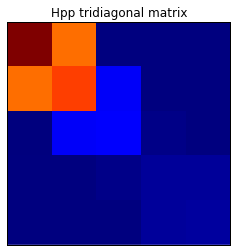

In [75]:
"""
Lanczos method for symmetric matrices orthogonalization / equivalent
to matrix factorization as a orthogonal/tridiagonal/orthogonal

Although the method appeared numerically unstable in our settings,
for dimension exceeding 6, it will be more useful, in the next steps
"""
size = 5
M = np.random.rand(size,size)
M = np.dot(M,M.T) #Symmetric
y = np.random.rand(size)

#Initialize matrix Vp and Hpp
Vp = np.zeros((size,size))
Hpp = np.zeros((size,size))
Vp[:,0] = y/np.linalg.norm(y)

for i in np.arange(1,size+1):
    #Compute next Vp
    v = np.dot(M,Vp[:,i-1])
    #orthogonalize
    minId = np.maximum(0,i-2)
    orth = np.dot(Vp[:,minId:i].T,v)
    Hpp[minId:i,i-1] = orth
    if( i < size ):
        v = v - np.dot(Vp[:,minId:i],orth)
        #Update Hpp
        Hpp[i,i-1] = np.linalg.norm(v)
        #Normalize vector and update V
        Vp[:,i] = v / Hpp[i,i-1]

#print str(np.dot(Vp,Vp.T))
#print str(Hpp)
#print str(np.dot(np.dot(Vp.T,M),Vp))

#check orthogonality of Vp
assert( np.allclose(np.identity(size),np.dot(Vp,Vp.T)) )

#Check the equivalence between M and VptHppVp
assert( np.allclose(Hpp,np.dot(Vp.T,np.dot(M,Vp))) )

#Show matrix Hpp
fig,ax = plt.subplots(1)
ax.set_title("Hpp tridiagonal matrix")
ax.imshow(Hpp,interpolation='none')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

### Krylov basis and practical resolution of linear equalities

As seen earlier, the solution $M^{-1} \vec{y}$ of $M \vec{x} = \vec{y}$ can be expressed in terms of $M^p \vec{y}, p = 0,1,\dots,r-1$, which led us to define the order-r Krylov basis.
	
We have then seen a way to express the p-order Krylov basis in a more stable way using the Arnoldi basis, and its Lanczos version $V_p$. We can now define $\vec{x_p}$, the approximation of the solution of $M \vec{x} - \vec{y} = 0$ in the order-p Arnoldi basis:

\begin{equation}
  \vec{x_p} = V_p \vec{s_p}
\end{equation}

From this can be defined common error metrics over this approximate solution, using the following vectors:

- The error vector: $\vec{e_p} = \vec{x} - \vec{x_p}$
- The residual vector: $\vec{r_p} = \vec{y} - M \vec{x_p} $

Krylov subspace related methods aims at minimizing $\vec{e_p}$ or $\vec{r_p}$ under appropriate norms.
One of the most reknown method, first derived by Lanczos aims at minimizing $Lcz(\vec{x_p})$ the scalar product of those two error vector, that can be also interpreted of the squared norm of the error vector using the scalar product defined by the matrix $M$:

\begin{align*}
  Lcz(\vec{x_p}) &= \| \vec{e_p} \|_M^2 \\
  &= \| \vec{x} - \vec{x_p} \|_M^2 \\
  &= ( \vec{x} - \vec{x_p})^\intercal M (\vec{x} - \vec{x_p})\\
  &= \vec{e_p}^\intercal . (M \vec{x} - M \vec{x_p})\\
  &= \vec{e_p}^\intercal . ( \vec{y} - M \vec{x_p})\\
  &= \vec{e_p}^\intercal . \vec{r_p}\\
\end{align*}

The Lanczos method can be viewed as the task of finding the vector $\vec{x_p} \in \mathcal{K}_p$ such that its distance to $\vec{x}$ is minimum in the inner product space $\mathcal{M}^n$ defined by $M$ from $\mathbb{R}^n$, for this method, we need $M$ to be symmetric and positive definite.

The vector $\vec{x_p}$ that satisfies this definition is the orthogonal projection of $x$ over $\mathcal{K}_p$ using the inner product $\langle .,. \rangle_M$.

Following the definition of the inner product $\langle .,. \rangle_M$ and the definition of the orthogonal projection operator,

\begin{aligned}
    P_{\mathcal{K}_p} : \mathcal{M}^n &\rightarrow \mathcal{K}_p \\
    \vec{x} &\rightarrow \vec{x_p}
\end{aligned}

in the space $\mathcal{M}^n$ we have that the range $\mathcal{K}_p$ and the nullspace $\mathcal{M}^n \setminus \mathcal{K}_p$ are orthogonal subspaces in direct sum, which means for us that $\mathcal{M}^n = \mathcal{K}_p \bigoplus_{M} \mathcal{M}^n \setminus \mathcal{K}_p$ and :

\begin{equation}
  \forall (a,b) \in \mathcal{M}^n \times \mathcal{M}^n \setminus \mathcal{K}_p, \langle a,b \rangle_M = 0
\end{equation}
  
By construction, it is obvious that $ \vec{e_p} = \vec{x} - \vec{x_p} \in \mathcal{M}^n \setminus \mathcal{K}_p$ so we have
	
\begin{align*}
  \langle \vec{x_p}, \vec{x} - \vec{x_p} \rangle_M &= 0 \quad \forall \vec{x_p} \in \mathcal{K}_p, \text{ and } x \in \mathbb{R}^n \\
  \vec{x_p} M ( \vec{x} - \vec{x_p} ) &= 0 \\
  \vec{x_p} . (\vec{y} - M \vec{x_p}) &= 0 \\
  \vec{x_p} . \vec{r_p} &= 0
\end{align*}

So we have that, in $\mathbb{R}^n$, the residual $\vec{r_p}$ is always orthogonal to all vectors in $\mathcal{K}_p$.

### Lanczos iterations : tridiagonal matrix factorization

Let's recall that $Lcz(\vec{x_p})$ reads:

\begin{align*}
  Lcz(\vec{x_p}) &= ( \vec{x} - \vec{x_p})^\intercal M (\vec{x} - \vec{x_p}) \\
  &= (\vec{x_p}^\intercal M \vec{x_p} + \vec{x}^\intercal M \vec{x} - 2 \vec{x_p}^\intercal M \vec{x}) \\
\end{align*}

We can further develop this expression using $\vec{x_p} = V_p \vec{s_p}$, and delete the constant terms to get:

\begin{align*}
  Lcz(\vec{x_p}) &= \vec{x_p}^\intercal M \vec{x_p} + \vec{x}^\intercal M \vec{x} - 2 \vec{x_p}^\intercal M \vec{x} \\
  Lcz(\vec{s_p}) &= \vec{s_p}^\intercal V_p^\intercal M V_p \vec{s_p} - 2 \vec{s_p}^\intercal V_p^\intercal \vec{y} \\
  &= 2( \frac{1}{2} \langle V_p^\intercal M V_p \vec{s_p}, \vec{s_p} \rangle - \langle V_p^\intercal \vec{y}, \vec{s_p} \rangle ) \\
  &= 2( \frac{1}{2} \langle H_{pp} \vec{s_p}, \vec{s_p} \rangle - \langle V_p^\intercal \vec{y}, \vec{s_p} \rangle ) \\
\end{align*}

Whose minimization can be reduced to

\begin{equation}
 Lcz(\vec{s_p})= \frac{1}{2} \langle H_{pp} \vec{s_p}, \vec{s_p} \rangle - \langle V_p^\intercal \vec{y}, \vec{s_p} \rangle \\
\end{equation}

which is a famous case of convex, and differentiable objective whose jacobian along $\vec{s_p}$ is:

\begin{equation}
  \frac{d Lcz(\vec{s_p})}{d \vec{x_p}} = H_{pp} \vec{s_p} - V_p^\intercal \vec{y}
\end{equation}

That vanish when $\vec{s_p}$ is the solution of $H_{pp} \vec{s_p} - V_p^\intercal \vec{y} = 0$

The positive definiteness of the tridiagonal $H_{pp}$ can be exploited by factorizing it using an alternative Choleski decomposition following the pattern $L_pD_pL_p^\intercal$, where $D_p$ is a diagonal matrix, and $L_p$ is an inferior bidiagonal matrix, with all diagonal entries equal to zeros.

We can perform the following iterative factorization with, at first step:

\begin{equation}
  \begin{pmatrix}
    h_{00}
  \end{pmatrix} =
  \begin{pmatrix}
    1
  \end{pmatrix}
  \begin{pmatrix}
    h_{00}
  \end{pmatrix}
  \begin{pmatrix}
    1
  \end{pmatrix}
\end{equation}

And at following steps, we can incrementally build the Choleski decomposition $L_pD_pL_p^\intercal$ of the tridiagonal $H_{pp}$:

\begin{align*}
  H_{pp} &=
  \begin{pmatrix}
    &   &            &   & 	    & 0       \\
    &   & H_{p-1p-1} &   & 	    & \vdots  \\
    &   &            &   & 	    & 0       \\
    &   &            &   & 	    & h_{p-1p}\\
    & 0 & \dots      & 0 & h_{pp-1} & h_{pp}
  \end{pmatrix} \\ &=
  \begin{pmatrix}
    &   &        &    & 	 &    0    \\
    &   & L_{p-1}&    & 	 &  \vdots \\
    &   &        &    & 	 &    0    \\
    &   &        &    & 	 &    0    \\
    & 0 & \dots  & 0  & l_{pp-1} &    1
  \end{pmatrix}
  \begin{pmatrix}
    &   &        & 	&   &    0    \\
    &   & D_{p-1}& 	&   &  \vdots \\
    &   &        & 	&   &    0    \\
    &   &        & 	&   &    0    \\
    & 0 & \dots  & \dots & 0 &  d_{pp}
  \end{pmatrix}
  \begin{pmatrix}
    &   &        	  & 	  &   &    0      \\
    &   & L_{p}^\intercal & 	  &   &  \vdots   \\
    &   &        	  & 	  &   &    0      \\
    &   &       	  & 	  &   &  l_{p-1p} \\
    & 0 & \dots  	  & \dots & 0 &     1 
  \end{pmatrix}
\end{align*}
	
Where $l_{pp-1} = \frac{h_{pp-1}}{d_{p-1p-1}}$ and $d_{pp}=h_{pp}-l_{pp-1}h_{pp-1}$

In the meantime, the vector $\vec{y_p} = V_p^\intercal \vec{y}$ has also to be updated as follows:

\begin{equation}
  \vec{y_p} =
  \begin{pmatrix}
    \begin{pmatrix}
      \\
      \vec{y_{p-1}}
      \\
      \\
    \end{pmatrix} \\
    \langle \vec{v_p},\vec{y} \rangle  \\
  \end{pmatrix}
\end{equation}


(3,)


[None, None, None]

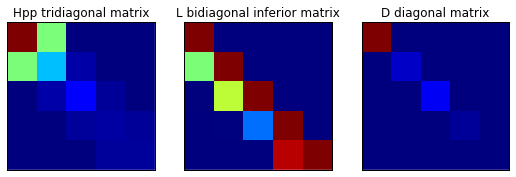

In [86]:
"""
Here, given a symmetrix matrix M, we will simultaneously build
its tridiagonal Lanczos factorization, Hpp as seen previously,
And the Choleski factorization of Hpp as LDLt
"""

size = 5
M = np.random.rand(size,size)
M = np.dot(M,M.T) #Symmetric
y = np.random.rand(size)

#Allocate matrices and vectors
Vp = np.zeros((size,size))
Hpp = np.zeros((size,size))
L = np.identity(size)
D = np.zeros((size,size))
yp = np.zeros(size)

#Initialize
Vp[:,0] = y/np.linalg.norm(y)

for i in np.arange(1,size+1):
    #Compute next Vp
    v = np.dot(M,Vp[:,i-1])
    #orthogonalize
    minId = np.maximum(0,i-2)
    orth = np.dot(Vp[:,minId:i].T,v)
    Hpp[minId:i,i-1] = orth
    if( i < size ):
        v = v - np.dot(Vp[:,minId:i],orth)
        #Update Hpp
        Hpp[i,i-1] = np.linalg.norm(v)
        #Normalize vector and update V
        Vp[:,i] = v / Hpp[i,i-1]
        #Update Yp
        yp[i] = np.dot(Vp[:,i],y)
    
    #Update the LDL^t factorization
    if( i > 1 ):
        L[i-1,i-2] = Hpp[i-1,i-2]/D[i-2,i-2]
        D[i-1,i-1] = Hpp[i-1,i-1]-L[i-1,i-2]*Hpp[i-1,i-2]
    else :
        D[i-1,i-1] = Hpp[i-1,i-1]

#check orthogonality of Vp
assert( np.allclose(np.identity(size),np.dot(Vp,Vp.T)) )
#Check the equivalence between M and VptHppVp
assert( np.allclose(Hpp,np.dot(Vp.T,np.dot(M,Vp))) )
#Check the LDLt Cholski factoization of Hpp
assert( np.allclose(Hpp,np.dot(L,np.dot(D,L.T))) )

#Show matrix Hpp, L and D
fig,ax = plt.subplots(1,3,figsize=(9,3))
ax[0].set_title("Hpp tridiagonal matrix")
ax[0].imshow(Hpp,interpolation='none')
ax[1].set_title("L bidiagonal inferior matrix")
ax[1].imshow(L,interpolation='none')
ax[2].set_title("D diagonal matrix")
ax[2].imshow(D,interpolation='none')
map(lambda a : a.get_xaxis().set_visible(False),ax)
map(lambda a : a.get_yaxis().set_visible(False),ax)

### Lanczos iterations in practice
  
We now have everything we need to design an algorithm that iteratively build:


- The Arnoldi orthogonalization of the Krylob basis $V_p$
- The tridiagonal $H_{pp}$ matrix
- The triangular matrix $L_p$, part of the $L_pD_pL_p^\intercal$ decomposition of $H_{pp}$
- The triangular matrix $D_p$, part of the $L_pD_pL_p^\intercal$ decomposition of $H_{pp}$
- The projection of $\vec{y}$ over the basis $V_p$ : $\vec{y_p}$


Which can be implemented as follows:

\begin{algorithm}
  \caption{Solve $M \vec{x} - \vec{y} = 0$}
    \begin{algorithmic}
      \REQUIRE $M \in S^n_{++}$ the positive definite cone
      \STATE \textbf{Initialization}
      \STATE $\vec{v_0} = \frac{\vec{y}}{\| \vec{y} \|}$
      \STATE $vec{y_p} = \vec{0}$
      \STATE $vec{L_p} = O_{n\times n}$
      \STATE $vec{D_p} = O_{n\times n}$
      \STATE $j = 1$
      \STATE $\vec{w} = M \vec{v_{0}}$
      \STATE \textbf{Iterations}
      \WHILE{$\vec{w} \neq \vec{0}$ and $j \leq n$}
      \STATE $\vec{w} = M \vec{v_{j-1}}$
      \IF{$j > 1$}
        \STATE $H_{j-2j-1} = H_{j-1j-2}$
        \STATE $\vec{w} = \vec{w} - H_{j-2j} \vec{v_{j-2}}$
      \ENDIF
      \STATE $H_{j-1j-1} = \langle \vec{w},\vec{v_{j-1}} \rangle $
      \STATE $\vec{w} = \vec{w} - H_{j-1j-1} \vec{v_{j-1}}$
      \IF{$\vec{w} \neq \vec{0}$}
        \STATE $H_{jj-1} = \| \vec{w} \|$
        \STATE $\vec{v_j} = \frac{\vec{w}}{H_{jj-1}}$
        \STATE $\vec{y_p}[j] = \langle \vec{v_j},\vec{y} \rangle $
        \IF{$j > 1$}
          \STATE $L_{j-1j-2} = \frac{H_{j-1j-2}}{D_{j-2j-2}}$
          \STATE $D_{j-1j-1} = H_{j-1j-1}-L_{j-1j-2}*H_{j-1,j-2}$
        \ELSE
          \STATE $D_{j-1j-1} = H_{j-1j-1}$
        \ENDIF
      \ENDIF
        \STATE $j=j+1$
       \ENDWHILE
      \STATE \textbf{Last Part}
      \STATE Solve diagonalized system: $L_pD_pL_p^\intercal \vec{s_p} = \vec{y_p}$
      \STATE Solution to initial problem is $\vec{x_p} = V_p^\intercal \vec{s_p}$
    \end{algorithmic}
\end{algorithm}

## Conjugate Gradient approach

Although the previous algorithm features some interesting properties, we can notice that it is not exactly a method that iteratively builds a solution vector. Instead, it iteratively builds a new problem, where $\vec{s_p}$, the $M$-projection of the solution $\hat{x}$ in the Krylov sub-space $\mathcal{K}_p$ expressed in the basis $V_p$ can be solved whithout too much effort, thanks to the triangular/diagonal structure of the $LDL^\intercal$ Choleski factorization.

An alternative formulation where the current solution $\vec{x_p}$ would be iteratively constructed in the Krylov subspace $\mathcal{K}_p$ using sequential vectors $\vec{v_k}, k = 0,1,\dots,p-1$ from the basis $V_p$ would allow us to save the computation needed to solve the full projection problem at each iteration, and the main update would look like:
  
\begin{equation} \label{eq:CoordinateConstructionSolution}
  \vec{x_{p+1}} = \vec{x_{p}} + \alpha_p \vec{v_{p}}
\end{equation}

This is the basic idea of the conjugate gradient algorithm, we will explain here:

### General Idea of Conjugate Gradient in the framework of Krylov methods

We must recall that the solution vector $\vec{s_p}$ at each step is the orthogonal projection of the general solution $\hat{x}$ over the Arnoldi basis $V_p$.
But it is orthogonal with respect to a specific inner product definition that uses $M \in S^n_{++}$, although the Arnoldi basis $V_p$ column vectors are orthogonal with respect to the canonical inner product that uses the identity matrix, so there is no guarantee that the first coordinates of $\vec{s_p}$ in $V_p$ will remain the same at the same position in $\vec{s_{p+1}}$ expressed in the new basis $V_{p+1}$.
This is why, at each iteration of the previous algorithm, the linear combination of vectors from $V_p$ had to be fully recomputed by solving a structured linear set of equations.

To overcome this problem, let's first recall that the problem to solve at each iteration as seen previously, reads:
      
\begin{align*}
  H_{pp} \vec{s_p} - V_p^\intercal \vec{y} = 0 \\
  H_{pp} \vec{s_p} = V_p^\intercal \vec{y} \\
  H_{pp} \vec{s_p} = \vec{y_p}
\end{align*}

As $\vec{y_p}$ and $\vec{y_{p+1}}$ only differs in the last coordinate that have been added to $\vec{y_{p+1}}$, as seen earlier, if we want to have a coordinate-wise resolution of the problem in the basis $V_p$, the same property should apply to $H_{pp} \vec{s_p}$, which could be translated in:

\begin{align*}
  \begin{pmatrix}
    1 	   & 0 	    & \dots  & 0 \\
    0 	   & \ddots & \ddots & \vdots \\
    \vdots & \ddots & 1      & 0 \\
    0 	   & \dots  & 0      & 0 \\
  \end{pmatrix}
  H_{p+1p+1} \vec{s_{p+1}} = H_{pp} \vec{s_p} \\
\end{align*}

Which imply that $H_{pp}$ should be constructed iteratively so that $H_{pp}$ and $H_{p+1p+1}$ only differs from the last line and the last column, but also that $H_{pp}$ should be diagonal for every $p$.

To achieve this simple construction scheme, it is obvious that $H_{pp}$ should be diagonal. To do so, we have to find a new Krylov basis $W_p$ such that our new $H_{pp}$ is diagonal:

\begin{equation}
  H_{pp} = W_{p} ^\intercal M W_{p}
\end{equation}

Fortunately, we don't need to take the Krylov basis design problem from the beginning to handle this constraint. We have already seen that the residue $\vec{r_p}$ is orthogonal to $\mathcal{K}_p$, and by construction, $\vec{r_p} \in \mathcal{K}_{p+1}$ :

\begin{equation}
  \vec{r_p} = M \vec{x_p} - \vec{y}
\end{equation}

with $\vec{y} \in \mathcal{K}_1$, $\vec{x_p} \in \mathcal{K}_p$ so $M \vec{x_p} \in \mathcal{K}_{p+1}$. We conclude that $\vec{r_p}$ lies in the orthogonal complement of $\mathcal{K}_p$ in $\mathcal{K}_{p+1}$ that we can write $\mathcal{K}_{p+1} \setminus \mathcal{K}_p$ which is of dimension $1$ and has an orthonormal basis $\vec{v_{p}}$. So every $\vec{r_p}$ can be written $\alpha \vec{v_{p}}$.

This last remark can be directly translated into a matrix equality, let $R_p$ be the matrix of all ordered $p$ first residual vectors $\vec{r_k}, k \in 0,1,\dots, p-1$, we can write:
    
\begin{equation}
  R_p = V_p \Delta_p
\end{equation}

Where $\Delta_p$ is a diagonal matrix, and we can now extend properties valid for the decomposition of $H_{pp}$ :

\begin{align*}
  &R_p^\intercal M R_p \\
  = &\Delta_p^\intercal V_p^\intercal M V_p \Delta_p \\
  = &\Delta_p^\intercal H_{pp} \Delta_p \\
  = &\tilde{H}_{pp} \\
\end{align*}

Where the matrix $\tilde{H}_{pp}$ that is equivalent to the projection of the linear operator $M$ over $\mathcal{K}_p$ expressed in the basis $R_p$ is still tridiagonal and positive definite, and admits an alternative Choleski decomposition of the form $ \tilde{H}_{pp} = \tilde{L}_p \tilde{D}_p \tilde{L}_p^\intercal $ such that we can write

\begin{align*}
  &R_p^\intercal M R_p &= \tilde{L}_p \tilde{D}_p \tilde{L}_p^\intercal \\
  \Leftrightarrow & \Delta_p^\intercal V_p^\intercal M V_p \Delta_p &= \tilde{L}_p \tilde{D}_p \tilde{L}_p^\intercal \\
  \Leftrightarrow & \tilde{L}_p^{-1} \Delta_p^\intercal V_p^\intercal M V_p \Delta_p \tilde{L}_p^{-\intercal} &= \tilde{D}_p \\
  \Leftrightarrow & W_{p} &= R_p \tilde{L}_p^{-\intercal} 
\end{align*}

Column vectors from $W_{p}$ are linear combinations of residual vectors, they form a basis of $\mathcal{K}_p$ and they features the desired property stated in paragraph ~\ref{paragraph:IdeaOfConjGrad} : they are all orthogonal to each other with respect to the inner product $\langle .,. \rangle_M$, $\mathcal{M}^n$.
	
Knowing that $\tilde{L}_p$ is bidiagonal inferior by construction, as seen in the Choleski factorization, we can also derive a short recurrence pattern over $\vec{w_0}, \vec{w_1}, \dots, \vec{w_{p-1}}$ the column vector of $W_p$, assuming that $\gamma_0, \gamma_1, \dots, \gamma_{p-1}$ are the subdiagonal elements of $\tilde{L}_p$:

\begin{align*}
  W_p \tilde{L}_p^t &= R_p \\
  \begin{pmatrix}
    \begin{pmatrix}&\\&\vec{w_0}\\&\end{pmatrix}
    \begin{pmatrix}&\\&\vec{w_1}\\&\end{pmatrix}
    \dots
    \begin{pmatrix}&\\&\vec{w_{p-1}}\\&\end{pmatrix}
    \end{pmatrix}
  \begin{pmatrix}
    1 & \gamma_0 & 0 & \dots & 0 \\
    0 & 1 & \gamma_1 & \ddots & \vdots \\
    \vdots & \ddots & \ddots & \ddots & 0 \\
    \vdots & \ddots & \ddots & 1 & \gamma_{p-2} \\
    0 & \dots & \dots & 0 & 1 \\
  \end{pmatrix} &=
  \begin{pmatrix}
    \begin{pmatrix}&\\&\vec{r_0}\\&\end{pmatrix}
    \begin{pmatrix}&\\&\vec{r_1}\\&\end{pmatrix}
    \dots
    \begin{pmatrix}&\\&\vec{r_{p-1}}\\&\end{pmatrix}
  \end{pmatrix}
\end{align*}

This formulation may give us a way to construct $w_{j+1}$ with a simple iterative scheme, assuming that $\vec{x_0} = \vec{0}$:

\begin{align*}
  &W_p \tilde{L}_p^{\intercal} &= R_p \\
  \Rightarrow & \vec{r_0} &= \vec{w_0} = \vec{y} - M \vec{x_0} \; \text{ and } \\
  & \vec{r_{j+1}} &= \vec{w_{j+1}} + \gamma_{j} \vec{w_j} \\
  \Leftrightarrow & \vec{w_{j+1}} &= \vec{r_{j+1}} - \gamma_{j} \vec{w_j} \\
\end{align*}

This relationship between $\vec{w_{j+1}}$ and $\vec{w_j}$ can be further exploited, if we use the fact that all vectors from $W_p$ are pairwise orthogonal with respect to the inner product defined by $M$:

\begin{align*}
  & \langle \vec{w_{j+1}},\vec{w_j} \rangle_M &= 0 \\
  \Leftrightarrow & \langle \vec{r_{j+1}} - \gamma_{j} \vec{w_j},\vec{w_j} \rangle_M &= 0 \\
  \Leftrightarrow & \vec{r_{j+1}}^\intercal M \vec{w_j} - \gamma_{j} \vec{w_j}^\intercal M \vec{w_j} &= 0 \\
  \Leftrightarrow & \gamma_{j} &= \frac{\vec{r_{j+1}}^\intercal M \vec{w_j}}{\vec{w_j}^\intercal M \vec{w_j}}
\end{align*}

We now need to see if $\vec{r_{j+1}}$ can be found using a simple recursion. To do so, we have to use the coordinate-wise construction of the solution exposed in eq ~\ref{eq:CoordinateConstructionSolution} :

\begin{align*}
  \vec{x_{j+1}} &= \vec{x_{j}} + \alpha_j \vec{w_{j}} \\
  \vec{y} - M \vec{x_{j+1}} &= \vec{y} - M \vec{x_{j}} - \alpha_j M \vec{w_{j}} \\
  \vec{r_{j+1}} &= \vec{r_{j}} - \alpha_j M \vec{w_{j}} \\
\end{align*}

Here, we can use the fact that $\vec{r_{p}}$ is orthogonal to $\mathcal{K}_p$, and especially $\vec{r_{j}}$ is orthogonal to $\vec{w_{j-1}}$ so that we can write:

\begin{align*}
  & \langle \vec{r_{j+1}},\vec{w_{j}} \rangle &= 0 \\
  \Leftrightarrow & \langle \vec{r_{j}} - \alpha_{j} M \vec{w_{j}},\vec{w_{j}} \rangle &= 0 \\
  \Leftrightarrow & \langle \vec{r_{j}},\vec{w_{j}} \rangle - \alpha_{j} \langle M \vec{w_{j}},\vec{w_{j}} \rangle &= 0 \\
  \Leftrightarrow & \vec{r_{j}}^\intercal \vec{w_{j}} - \alpha_{j} \vec{w_{j}}^\intercal M \vec{w_{j}} &= 0 \\
  \Leftrightarrow & \alpha_{j} &= \frac{ \vec{r_{j}}^\intercal \vec{w_{j}} }{ \vec{w_{j}}^\intercal M \vec{w_{j}} }
\end{align*}

### Conjugate Gradient algorithm in practice

The force of the Conjugate gradient algorithm lies in the fact that it iteratively builds a diagonal problem which can be solved one coordinate per iteration, without ``forgetting'' about the previous iterations. More interestingly, it is not solved in the canonical coordinate system of $\mathbb{R}^n$ but instead in a basis of pairwise orthogonal vectors with respect to the matrix $M$, called ``conjugate vectors'', which are iteratively built using the gradient of the function $f(\vec{x})$ we want to minimize at the current solution estimate : $f(\vec{x}) = \frac{1}{2} (\vec{x}-\vec{\hat{x}} ) (M \vec{x} - \vec{y})  $.

By design, these vectors are able to catch a large part of the error at every iteration, and especially, if the matrix $M$ defines an ellipsoid with an important anisotropy, the conjugate strategy helps to avoid the drawback of descent methods that are often ``stuck'' in valleys.

The algorithm reads:

\begin{algorithm}
  \caption{Solve $M \vec{x} - \vec{y} = 0$}
    \begin{algorithmic}
      \REQUIRE $M \in S^n_{++}$ the positive definite cone
      \STATE \textbf{Initialization}
      \STATE $\vec{r_0} = \vec{y}$
      \STATE $\vec{w_0} = \vec{r_0}$
      \STATE $j = 1$
      \STATE \textbf{Iterations}
      \WHILE{$j \leq n$}
      \STATE $\alpha_{i-1} = \frac{ \vec{r_{i-1}}^\intercal \vec{w_{i-1}} }{ \vec{w_{i-1}}^\intercal M \vec{w_{i-1}} }$
      \STATE $\vec{x_i} = \vec{x_{i-1}} + \alpha_{i-1} \vec{w_{j-1}}$
      \STATE $\vec{r_i} = \vec{r_{i-1}} - \alpha_{i-1} M\vec{w_{j-1}}$
      \IF{$\vec{r_i} \neq \vec{0}$}
        \STATE $\gamma_{i-1} = \frac{ \vec{r_{i}}^\intercal M \vec{w_{i-1}} }{ \vec{w_{i-1}}^\intercal M \vec{w_{i-1}} }$
        \STATE $\vec{w_i} = \vec{r_{i}} - \gamma_{i-1} \vec{w_{j-1}}$
      \ELSE
          \STATE End iterations
      \ENDIF
       \ENDWHILE
    \end{algorithmic}
\end{algorithm}